# NLPeasy Workshop - OKCupid (2/2)

In this part, we will try to use the enrichments generated in part 1 for more in-depth analysis of the data.

Let's see what knowledge we gain about the people from what they wrote.

First, let's again import some stuff we need to train a model:

In [1]:
import pandas as pd
import numpy as np
%load_ext autoreload
%autoreload 2

from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.utils.multiclass import unique_labels

from pprint import pprint

import seaborn as sns
import matplotlib.pyplot as plt

Also if you are on MyBinder you need to shutdown 

In [ ]:
!./stop_elk.sh

We have prepared the full enriched data set for you, you can load it now:

In [2]:
okc_enriched = pd.read_pickle('okc_enriched_demo.pickle')

In [3]:
pd.set_option('display.max_columns', None)
okc_enriched.head()

,age,body_type,diet,drinks,drugs,education,myself_summary,typical_friday_night,message_me_if,ethnicity,height,income,job,last_online,location,offspring,orientation,pets,religion,sex,sign,smokes,speaks,status,height_cm,city,geolocation,likes_dogs,likes_cats,language,language_count,religion_clean,religion_remainder,sign_clean,sign_remainder,myself_summary_sentiment,typical_friday_night_sentiment,message_me_if_messageme,myself_summary_wc,myself_summary_entity_DATE,myself_summary_subj,myself_summary_verb,myself_summary_num_ADP,myself_summary_num_PRON,myself_summary_num_PUNCT,myself_summary_num_SPACE,myself_summary_num_VERB,myself_summary_num_PART,myself_summary_num_SCONJ,myself_summary_num_AUX,myself_summary_num_DET,myself_summary_num_NOUN,myself_summary_num_CCONJ,myself_summary_num_ADJ,myself_summary_num_ADV,myself_summary_num_PROPN,myself_summary_num_NUM,myself_summary_vec,myself_summary_vec_normalized,myself_summary_entity_CARDINAL,myself_summary_entity_GPE,myself_summary_ents,myself_summary_num_X,myself_summary_num_SYM,myself_summary_entity_ORDINAL,myself_summary_num_INTJ,myself_summary_entity_NORP,myself_summary_entity_LANGUAGE,myself_summary_entity_PERSON,myself_summary_entity_ORG,myself_summary_entity_LOC,myself_summary_entity_TIME,myself_summary_entity_PRODUCT,myself_summary_entity_EVENT,myself_summary_entity_QUANTITY,typical_friday_night_wc,typical_friday_night_subj,typical_friday_night_verb,typical_friday_night_num_VERB,typical_friday_night_num_PART,typical_friday_night_num_PRON,typical_friday_night_num_ADP,typical_friday_night_num_PUNCT,typical_friday_night_num_AUX,typical_friday_night_num_SCONJ,typical_friday_night_num_DET,typical_friday_night_num_NOUN,typical_friday_night_vec,typical_friday_night_vec_normalized,typical_friday_night_num_PROPN,typical_friday_night_num_CCONJ,typical_friday_night_entity_ORG,typical_friday_night_ents,typical_friday_night_num_ADV,typical_friday_night_num_ADJ,typical_friday_night_entity_DATE,typical_friday_night_entity_CARDINAL,typical_friday_night_num_NUM,typical_friday_night_entity_TIME,typical_friday_night_entity_FAC,typical_friday_night_num_INTJ,typical_friday_night_entity_PERSON,typical_friday_night_num_SPACE,typical_friday_night_entity_GPE,typical_friday_night_entity_LOC,typical_friday_night_num_SYM,typical_friday_night_num_X,typical_friday_night_entity_QUANTITY,message_me_if_wc,message_me_if_subj,message_me_if_verb,message_me_if_num_PRON,message_me_if_num_VERB,message_me_if_num_PART,message_me_if_num_AUX,message_me_if_num_ADP,message_me_if_num_DET,message_me_if_num_NOUN,message_me_if_num_PUNCT,message_me_if_num_ADJ,message_me_if_num_CCONJ,message_me_if_num_SCONJ,message_me_if_vec,message_me_if_vec_normalized,message_me_if_num_ADV,message_me_if_num_SPACE,message_me_if_num_PROPN,message_me_if_entity_LANGUAGE,message_me_if_ents,message_me_if_num_INTJ,message_me_if_entity_ORG,message_me_if_entity_LOC,message_me_if_entity_PERSON,message_me_if_entity_CARDINAL,message_me_if_entity_DATE,message_me_if_num_NUM,message_me_if_entity_NORP,message_me_if_entity_TIME,message_me_if_num_SYM,message_me_if_num_X,message_me_if_entity_GPE,message_me_if_entity_ORDINAL,message_me_if_entity_MONEY,myself_summary_entity_PERCENT,myself_summary_entity_WORK_OF_ART,typical_friday_night_entity_NORP,message_me_if_entity_PERCENT,myself_summary_entity_MONEY,typical_friday_night_entity_ORDINAL,typical_friday_night_entity_PRODUCT,myself_summary_entity_FAC,typical_friday_night_entity_WORK_OF_ART,message_me_if_entity_QUANTITY,message_me_if_entity_PRODUCT,typical_friday_night_entity_MONEY,message_me_if_entity_FAC,message_me_if_entity_EVENT,message_me_if_entity_WORK_OF_ART,typical_friday_night_entity_PERCENT,typical_friday_night_entity_EVENT,typical_friday_night_entity_LANGUAGE,myself_summary_entity_LAW,typical_friday_night_entity_LAW,message_me_if_entity_LAW
0,22,a little extra,strictly anything,socially,never,working on college/university,about me: i would love to think that i was so...,trying to find someone to hang out w

You may choose your own example of what you would like to find out with this dataset.

Our goal is to find out whether we can predict university graduates.

In [4]:
for i in okc_enriched.columns:
    print(i)

age
body_type
diet
drinks
drugs
education
myself_summary
typical_friday_night
message_me_if
ethnicity
height
income
job
last_online
location
offspring
orientation
pets
religion
sex
sign
smokes
speaks
status
height_cm
city
geolocation
likes_dogs
likes_cats
language
language_count
religion_clean
religion_remainder
sign_clean
sign_remainder
myself_summary_sentiment
typical_friday_night_sentiment
message_me_if_messageme
myself_summary_wc
myself_summary_entity_DATE
myself_summary_subj
myself_summary_verb
myself_summary_num_ADP
myself_summary_num_PRON
myself_summary_num_PUNCT
myself_summary_num_SPACE
myself_summary_num_VERB
myself_summary_num_PART
myself_summary_num_SCONJ
myself_summary_num_AUX
myself_summary_num_DET
myself_summary_num_NOUN
myself_summary_num_CCONJ
myself_summary_num_ADJ
myself_summary_num_ADV
myself_summary_num_PROPN
myself_summary_num_NUM
myself_summary_vec
myself_summary_vec_normalized
myself_summary_entity_CARDINAL
myself_summary_entity_GPE
myself_summary_ents
myself_sum

## Can we predict university graduates from the OK cupid dataset?

Let's try to construct a binary feature 'university_graduate' 0/1 from the education column.
What options do we have?

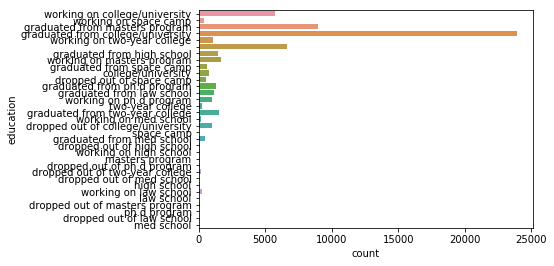

In [5]:
ax = sns.countplot(y='education', data= okc_enriched)

In [6]:
okc_enriched['education'].unique()

array(['working on college/university', 'working on space camp',
       'graduated from masters program',
       'graduated from college/university', 'working on two-year college',
       '', 'graduated from high school', 'working on masters program',
       'graduated from space camp', 'college/university',
       'dropped out of space camp', 'graduated from ph.d program',
       'graduated from law school', 'working on ph.d program',
       'two-year college', 'graduated from two-year college',
       'working on med school', 'dropped out of college/university',
       'space camp', 'graduated from med school',
       'dropped out of high school', 'working on high school',
       'masters program', 'dropped out of ph.d program',
       'dropped out of two-year college', 'dropped out of med school',
       'high school', 'working on law school', 'law school',
       'dropped out of masters program', 'ph.d program',
       'dropped out of law school', 'med school'], dtype=object)

We will use some categories of the education column as indicative for university_graduate = true

In [7]:
okc_enriched['university_graduate'] = 0
okc_enriched.loc[okc_enriched['education'] == 'graduated from college/university'
             ,'university_graduate'] = 1
okc_enriched.loc[okc_enriched['education'] == 'graduated from masters program'
             ,'university_graduate'] = 1
okc_enriched.loc[okc_enriched['education'] == 'graduated from ph.d program'
             ,'university_graduate'] = 1
okc_enriched.loc[okc_enriched['education'] == 'graduated from law school'
             ,'university_graduate'] = 1
okc_enriched.loc[okc_enriched['education'] == 'graduated from med school'
             ,'university_graduate'] = 1

Let's see how balanced this is:

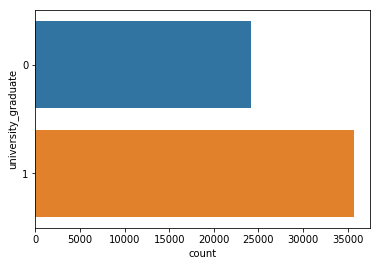

In [8]:
ax = sns.countplot(y='university_graduate', data= okc_enriched)

## Build Predictor variables
Let's see which predictors we want to use. We will do two round of prediction:
1. Analyse with simple text features like count of words, count of adjectives, along with some ohter attributes the users have provided (age, languages they speak...)
2. Include the word vector of all text they have written - can this add to prediction power?

Let's define all predictors we want to use for (1):

In [10]:
col_features_without_vec = [
'myself_summary_num_ADJ',
'myself_summary_num_ADP',
'myself_summary_num_ADV',
'myself_summary_num_CCONJ',
'myself_summary_num_DET',
'myself_summary_num_NOUN',
'myself_summary_num_PART',
'myself_summary_num_PRON',
'myself_summary_num_PUNCT',
'myself_summary_num_VERB',
'myself_summary_wc', 'myself_summary_sentiment', 'age', 'language_count']

Let's also transform the word vector of 'all_free_text' to features:

In [9]:
okc_enriched['myself_summary_vec_normalized'].head().apply(pd.Series)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
0,-0.013729,0.044563,-0.062591,-0.020607,0.016665,0.010751,-0.003352,-0.038356,-0.003329,0.649443,-0.066462,0.024244,0.031245,-0.015396,-0.040220,-0.011678,-0.032100,0.322901,-0.064775,-0.002058,0.009218,-0.013752,-0.014122,-0.015472,-3.488536e-03,0.016693,-0.014501,-0.028575,0.028465,-0.032975,-0.011836,0.033663,-0.026424,0.021645,0.027870,-0.025900,0.020057,0.015133,-0.021988,-0.019565,-0.014972,0.015984,-0.011901,-0.018322,0.021023,0.016501,-0.050194,-0.000451,0.012485,0.004480,-0.017116,0.008448,0.007892,-0.020733,0.022722,0.012983,-0.018984,-0.016095,0.006778,-0.012958,-0.010302,-0.027127,-0.021675,0.060060,0.011625,-0.036551,-0.004415,0.026321,0.007608,0.039282,0.004623,0.016912,0.059333,-0.007684,0.026613,0.024319,0.032535,-0.023057,-0.024121,0.059867,-0.006840,0.012719,-0.040948,-0.008445,0.002171,-0.068854,0.027378,-0.035131,0.088160,0.003161,-0.038174,-0.008023,-0.032568,0.024120,0.023155,-0.002845,0.004301,-0.017333,-0.006936,-0.017707,-0.004564,0.007597,-0.017945,-0.017779,0.043083,-0.200105,0.035505,-0.011910,-0.002196,0.012005,0.026268,-0.062719,0.029099,-0.032052,-0.007599,-0.006442,-0.000884,-0.014391,-0.005959,-0.008941,0.035172,-0.031421,-0.005295,0.001199,0.033927,0.030726,-0.016240,-0.033428,0.014317,-0.003478,-0.009040,-0.005223,-0.046637,0.021345,0.016207,0.006291,-0.003446,-0.006108,-0.013021,-0.001622,-0.471134,0.037670,0.030467,0.007357,-0.013237,-0.016729,-0.028016,0.009043,0.001819,-0.028570,0.004101,0.011970,0.018314,-0.002161,-0.023913,-0.009794,-0.013912,-0.025594,-0.000436,-0.033601,-0.011304,0.004720,-0.016698,-0.006642,-0.013677,-0.044811,0.024421,-0.019364,0.031511,0.008075,-0.013184,-0.007232,0.044483,-0.037320,-0.010829,0.012818,-0.010951,-0.002587,0.014063,-0.020589,0.002392,-0.019573,-0.036844,-0.021761,-0.006479,-0.007073,-0.021914,-0.015020,0.025427,0.020834,0.002845,0.002257,-0.026669,-0.009828,0.014350,0.028658,-0.005601,-0.036978,0.004979,0.057696,-0.007378,-0.027370,-0.024212,-0.011860,0.044687,0.014374,0.020113,0.004120,0.016498,0.002685,-0.034238,-0.025478,-0.020382,-0.063620,0.020921,0.053157,-0.009809,0.006716,-0.062339,0.002644,0.016645,0.001353,-0.008978,0.014615,0.001337,-0.016071,0.000889,0.029266,-0.009384,-0.014347,-0.046550,0.007182,0.018351,0.041302,-0.014232,-0.028072,-0.003775,-0.020295,-0.017886,0.041245,0.013678,0.008398,-0.003541,0.032967,0.032658,-0.044563,-0.039461,-0.039287,-0.047101,0.054755,0.007673,-0.026615,-0.033768,0.007043,0.005401,0.053862,0.030007,-0.026008,-0.014554,0.021500,0.014007,0.051034,0.012156,0.022034,0.026783,-0.014001,-0.009753,0.029962,0.104169,0.020725,0.006427,-0.003372,-0.038115,-0.041452,-0.041417,0.001224,0.003424,0.010852,0.005098,0.057648,0.048921,0.002091,0.010302,-0.023543,-0.020451,-0.024295,0.042377,-0.026159,0.037658,-0.004601,-0.057327,0.011619,-0.019874,-0.013083,0.014051,0.006952,-0.006163,-0.013233,0.006851,0.027095
1,-0.007905,0.061625,-0.065937,-0.036019,

In [13]:
df_text_vec = okc_enriched['myself_summary_vec'].apply(pd.Series)

In [14]:
df_text_vec.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
0,-0.045258,0.146902,-0.206330,-0.067932,0.054936,0.035440,-0.011051,-0.126439,-0.010974,2.140891,-0.219092,0.079922,0.102998,-0.050753,-0.132585,-0.038497,-0.105817,1.064444,-0.213531,-0.006786,0.030388,-0.045334,-0.046553,-0.051003,-0.011500,0.055029,-0.047803,-0.094197,0.093836,-0.108703,-0.039016,0.110971,-0.087108,0.071353,0.091873,-0.085381,0.066119,0.049885,-0.072482,-0.064497,-0.049356,0.052691,-0.039230,-0.060400,0.069302,0.054396,-0.165466,-0.001487,0.041156,0.014769,-0.056423,0.027848,0.026017,-0.068348,0.074903,0.042797,-0.062580,-0.053056,0.022345,-0.042715,-0.033961,-0.089425,-0.071452,0.197987,0.038323,-0.120491,-0.014554,0.086767,0.025081,0.129493,0.015239,0.055749,0.195593,-0.025331,0.087728,0.080168,0.107252,-0.076009,-0.079514,0.197352,-0.022549,0.041929,-0.134985,-0.027840,0.007156,-0.226976,0.090251,-0.115810,0.290621,0.010421,-0.125839,-0.026448,-0.107360,0.079511,0.076331,-0.009379,0.014179,-0.057137,-0.022865,-0.058372,-0.015045,0.025043,-0.059155,-0.058609,0.142025,-0.659645,0.117044,-0.039261,-0.007238,0.039574,0.086593,-0.206755,0.095926,-0.105660,-0.025050,-0.021236,-0.002915,-0.047439,-0.019645,-0.029473,0.115946,-0.103581,-0.017456,0.003952,0.111842,0.101289,-0.053536,-0.110196,0.047195,-0.011466,-0.029799,-0.017218,-0.153740,0.070365,0.053428,0.020739,-0.011361,-0.020134,-0.042925,-0.005346,-1.553097,0.124178,0.100434,0.024253,-0.043637,-0.055146,-0.092356,0.029812,0.005997,-0.094180,0.013519,0.039458,0.060372,-0.007124,-0.078830,-0.032287,-0.045860,-0.084369,-0.001437,-0.110764,-0.037265,0.015560,-0.055046,-0.021894,-0.045086,-0.147719,0.080505,-0.063834,0.103875,0.026620,-0.043462,-0.023839,0.146638,-0.123025,-0.035696,0.042256,-0.036100,-0.008527,0.046359,-0.067871,0.007885,-0.064524,-0.121456,-0.071736,-0.021358,-0.023316,-0.072239,-0.049515,0.083821,0.068680,0.009379,0.007442,-0.087913,-0.032398,0.047305,0.094470,-0.018464,-0.121898,0.016412,0.190196,-0.024322,-0.090227,-0.079816,-0.039097,0.147311,0.047384,0.066301,0.013583,0.054385,0.008850,-0.112866,-0.083988,-0.067191,-0.209722,0.068967,0.175232,-0.032334,0.022139,-0.205500,0.008716,0.054870,0.004461,-0.029596,0.048179,0.004406,-0.052979,0.002930,0.096474,-0.030933,-0.047296,-0.153451,0.023676,0.060494,0.136152,-0.046914,-0.092539,-0.012443,-0.066903,-0.058962,0.135963,0.045091,0.027685,-0.011673,0.108675,0.107657,-0.146903,-0.130082,-0.129510,-0.155269,0.180501,0.025294,-0.087737,-0.111316,0.023217,0.017806,0.177556,0.098917,-0.085734,-0.047978,0.070876,0.046174,0.168234,0.040071,0.072636,0.088290,-0.046155,-0.032150,0.098769,0.343392,0.068322,0.021186,-0.011115,-0.125646,-0.136648,-0.136532,0.004034,0.011287,0.035774,0.016807,0.190038,0.161268,0.006894,0.033960,-0.077609,-0.067417,-0.080089,0.139697,-0.086232,0.124139,-0.015166,-0.188980,0.038302,-0.065516,-0.043127,0.046318,0.022916,-0.020315,-0.043623,0.022584,0.089320
1,-0.026310,0.205113,-0.219463,-0.119884,0.08

Combine all features we generated in one df:

In [15]:
df_without_vec = okc_enriched[col_features_without_vec]
all_features_df = df_without_vec.merge(df_text_vec, left_index = True, right_index= True)

In [16]:
all_features_df.head()

,myself_summary_num_ADJ,myself_summary_num_ADP,myself_summary_num_ADV,myself_summary_num_CCONJ,myself_summary_num_DET,myself_summary_num_NOUN,myself_summary_num_PART,myself_summary_num_PRON,myself_summary_num_PUNCT,myself_summary_num_VERB,myself_summary_wc,myself_summary_sentiment,age,language_count,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
0,28.0,20.0,12.0,10.0,25.0,45.0,15.0,22.0,32.0,37.0,272,0.9925,22,1,-0.045258,0.146902,-0.206330,-0.067932,0.054936,0.035440,-0.011051,-0.126439,-0.010974,2.140891,-0.219092,0.079922,0.102998,-0.050753,-0.132585,-0.038497,-0.105817,1.064444,-0.213531,-0.006786,0.030388,-0.045334,-0.046553,-0.051003,-0.011500,0.055029,-0.047803,-0.094197,0.093836,-0.108703,-0.039016,0.110971,-0.087108,0.071353,0.091873,-0.085381,0.066119,0.049885,-0.072482,-0.064497,-0.049356,0.052691,-0.039230,-0.060400,0.069302,0.054396,-0.165466,-0.001487,0.041156,0.014769,-0.056423,0.027848,0.026017,-0.068348,0.074903,0.042797,-0.062580,-0.053056,0.022345,-0.042715,-0.033961,-0.089425,-0.071452,0.197987,0.038323,-0.120491,-0.014554,0.086767,0.025081,0.129493,0.015239,0.055749,0.195593,-0.025331,0.087728,0.080168,0.107252,-0.076009,-0.079514,0.197352,-0.022549,0.041929,-0.134985,-0.027840,0.007156,-0.226976,0.090251,-0.115810,0.290621,0.010421,-0.125839,-0.026448,-0.107360,0.079511,0.076331,-0.009379,0.014179,-0.057137,-0.022865,-0.058372,-0.015045,0.025043,-0.059155,-0.058609,0.142025,-0.659645,0.117044,-0.039261,-0.007238,0.039574,0.086593,-0.206755,0.095926,-0.105660,-0.025050,-0.021236,-0.002915,-0.047439,-0.019645,-0.029473,0.115946,-0.103581,-0.017456,0.003952,0.111842,0.101289,-0.053536,-0.110196,0.047195,-0.011466,-0.029799,-0.017218,-0.153740,0.070365,0.053428,0.020739,-0.011361,-0.020134,-0.042925,-0.005346,-1.553097,0.124178,0.100434,0.024253,-0.043637,-0.055146,-0.092356,0.029812,0.005997,-0.094180,0.013519,0.039458,0.060372,-0.007124,-0.078830,-0.032287,-0.045860,-0.084369,-0.001437,-0.110764,-0.037265,0.015560,-0.055046,-0.021894,-0.045086,-0.147719,0.080505,-0.063834,0.103875,0.026620,-0.043462,-0.023839,0.146638,-0.123025,-0.035696,0.042256,-0.036100,-0.008527,0.046359,-0.067871,0.007885,-0.064524,-0.121456,-0.071736,-0.021358,-0.023316,-0.072239,-0.049515,0.083821,0.068680,0.009379,0.007442,-0.087913,-0.032398,0.047305,0.094470,-0.018464,-0.121898,0.016412,0.190196,-0.024322,-0.090227,-0.079816,-0.039097,0.147311,0.047384,0.066301,0.013583,0.054385,0.008850,-0.112866,-0.083988,-0.067191,-0.209722,0.068967,0.175232,-0.032334,0.022139,-0.205500,0.008716,0.054870,0.004461,-0.029596,0.048179,0.004406,-0.052979,0.002930,0.096474,-0.030933,-0.047296,-0.153451,0.023676,0.060494,0.136152,-0.046914,-0.092539,-0.012443,-0.066903,-0.058962,0.135963,0.045091,0.027685,-0.011673,0.108675,0.107657,-0.146903,-0.130082,-0.129510,-0.155269,0.180501,0.025294,-0.087737,-0.111316,0.023217,0.017806,0.177556,0.098917,-0.085734,-0.047978,0.070876,0.046174,0.168234,0.040071,0.072636,0.088290,-0.046155,

See where we have missing values:

In [17]:
all_features_df.isna().sum()

myself_summary_num_ADJ       8464
myself_summary_num_ADP       8975
myself_summary_num_ADV      10922
myself_summary_num_CCONJ    10884
myself_summary_num_DET       8935
myself_summary_num_NOUN      6977
myself_summary_num_PART     15399
myself_summary_num_PRON      8579
myself_summary_num_PUNCT     6533
myself_summary_num_VERB      7410
myself_summary_wc               0
myself_summary_sentiment        0
age                             0
language_count                  0
0                            5488
1                            5488
2                            5488
3                            5488
4                            5488
5                            5488
6                            5488
7                            5488
8                            5488
9                            5488
10                           5488
11                           5488
12                           5488
13                           5488
14                           5488
15            

In [18]:
all_features_df.shape

(59946, 314)

... and drop them:

In [19]:
all_features_df = all_features_df.dropna()

In [20]:
all_features_df.shape

(39988, 314)

Build the target vec:

In [21]:
okc_target = okc_enriched[okc_enriched.index.isin(all_features_df.index)]
target = np.array(okc_target['university_graduate'])

In [22]:
len(target)

39988

### 1. Predict with non-vec features only
This is the set of features we want to include:

In [23]:
features_without_vec = all_features_df[col_features_without_vec]

### Train / Test

In [24]:
train_features_without_vec, test_features_without_vec, train_target_without_vec, test_target_without_vec = train_test_split(features_without_vec, target, test_size=0.25, random_state = 42)

In [25]:
train_features_without_vec.shape

(29991, 14)

In [26]:
test_features_without_vec.shape

(9997, 14)

### Predict and fit

In [27]:
rf = RandomForestClassifier(n_estimators=100, random_state=42, verbose = 2)
pprint(rf.get_params())

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 2,
 'warm_start': False}


In [28]:
rf.fit(train_features_without_vec, train_target_without_vec)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
b

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    4.2s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=42, verbose=2, warm_start=False)

In [29]:
predictions_without_vec = rf.predict(test_features_without_vec)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished


In [30]:
print("Accuracy, Random Forest: ", metrics.accuracy_score(test_target_without_vec, predictions_without_vec))
print("AUC Score, Random Forest: ", metrics.roc_auc_score(test_target_without_vec, predictions_without_vec))
print(metrics.classification_report(test_target_without_vec, predictions_without_vec))

Accuracy, Random Forest:  0.6766029808942683
AUC Score, Random Forest:  0.6078693790831126
              precision    recall  f1-score   support

           0       0.66      0.32      0.43      3811
           1       0.68      0.90      0.77      6186

   micro avg       0.68      0.68      0.68      9997
   macro avg       0.67      0.61      0.60      9997
weighted avg       0.67      0.68      0.64      9997



Function to plot confusion matrix

In [31]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = "Normalized confusion matrix"
        else:
            title = "Confusion matrix, without normalization"

    #compute confusion matrix
    cm = metrics.confusion_matrix(y_true, y_pred)
    classes = classes[unique_labels(y_true, y_pred)]
    
    if normalize:
        cm = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")
        
    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation = 'nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    
    #we want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # and label them with respective list entries
           xticklabels=classes, yticklabels=classes, 
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    
    #Rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right', 
            rotation_mode = 'anchor')
    
    #Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2. 
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, (i+0.4)*0.6, format(cm[i, j], fmt),
                    ha='center', va='center', 
                    color='white' if cm[i,j] > thresh else 'black')
    
    fig.tight_layout()
    return ax

np.set_printoptions(precision=2)

Function for ROC curve:

In [32]:
def plot_roc_curve(test_predictions, test_target):
    rf_roc_auc = metrics.roc_auc_score(y_score = test_predictions, y_true = test_target)
    fpr, tpr, thresholds = metrics.roc_curve(test_target, test_predictions)
    plt.figure()
    plt.plot(fpr, tpr, label='Random Forest (area = %0.4f)'% rf_roc_auc)
    plt.plot([0,1], [0,1], 'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('Receiver operating characteristic (ROC)')
    plt.legend(loc='lower right')
    plt.show()

Confusion matrix, without normalization
[[1214 2597]
 [ 636 5550]]
Normalized confusion matrix
[[0.32 0.68]
 [0.1  0.9 ]]


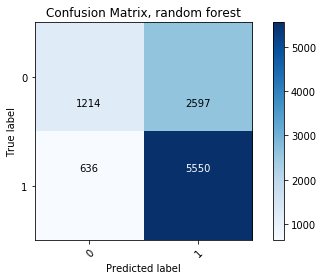

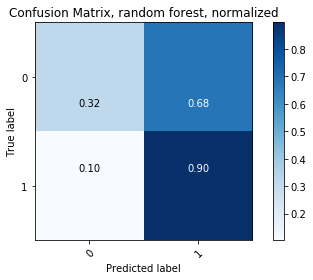

In [33]:
plot_confusion_matrix(test_target_without_vec, predictions_without_vec, classes = np.array([0,1]),
                      title="Confusion Matrix, random forest")
plot_confusion_matrix(test_target_without_vec, predictions_without_vec, classes = np.array([0,1]), normalize=True,
                      title="Confusion Matrix, random forest, normalized")

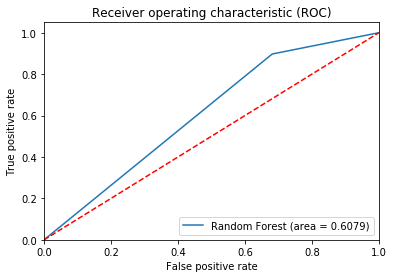

In [34]:
plot_roc_curve(predictions_without_vec, test_target_without_vec)

In [35]:
prob_predictions_without_vec = rf.predict_proba(test_features_without_vec)[:,1]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished


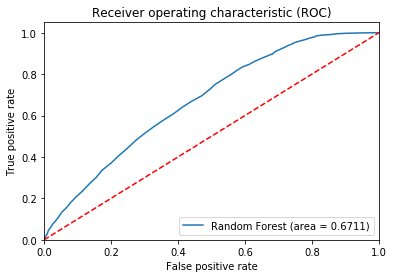

In [36]:
plot_roc_curve(prob_predictions_without_vec, test_target_without_vec)

Function to plot importances:

In [37]:
def plot_importance_top(rf, features, top_n=30):
    importances = rf.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    x = np.arange(len(features.columns))
    y = importances[indices]
    x_labels = features.columns[indices]
    
    plt.figure()
    plt.bar(x[0:top_n], y[0:top_n], tick_label = x_labels[0:top_n])
    plt.xticks(rotation=90)


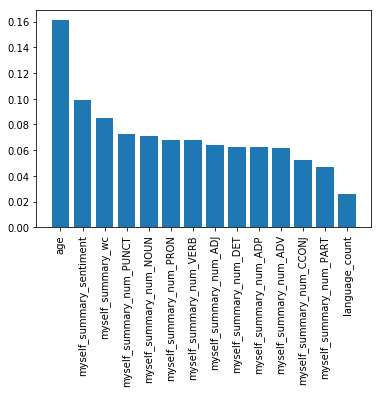

In [38]:
plot_importance_top(rf, features_without_vec)

### 2. Predict with all features, including vec
i.e., now we use all_features_df

In [39]:
train_predictors, test_predictors, train_target, test_target = train_test_split(all_features_df, target, test_size=0.25, random_state = 42)

In [40]:
rf2 = RandomForestClassifier(n_estimators=100, random_state=42, verbose = 2)
rf2.fit(train_predictors, train_target)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   47.3s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=42, verbose=2, warm_start=False)

Predict and see result:

In [41]:
predictions = rf2.predict(test_predictors)
print("Accuracy, Random Forest: ", metrics.accuracy_score(test_target, predictions))
print("AUC Score, Random Forest: ", metrics.roc_auc_score(test_target, predictions))
print(metrics.classification_report(test_target, predictions))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Accuracy, Random Forest:  0.691407422226668
AUC Score, Random Forest:  0.6307624872713908
              precision    recall  f1-score   support

           0       0.67      0.38      0.48      3811
           1       0.70      0.89      0.78      6186

   micro avg       0.69      0.69      0.69      9997
   macro avg       0.68      0.63      0.63      9997
weighted avg       0.69      0.69      0.67      9997



[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished


Confusion matrix, without normalization
[[1431 2380]
 [ 705 5481]]
Normalized confusion matrix
[[0.38 0.62]
 [0.11 0.89]]


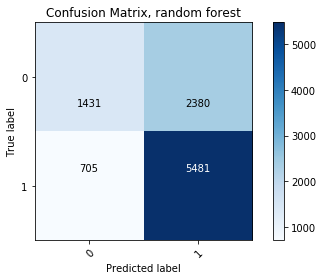

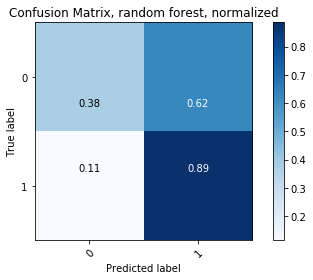

In [42]:
plot_confusion_matrix(test_target, predictions, classes = np.array([0,1]),
                      title="Confusion Matrix, random forest")
plot_confusion_matrix(test_target, predictions, classes = np.array([0,1]), normalize=True,
                      title="Confusion Matrix, random forest, normalized")

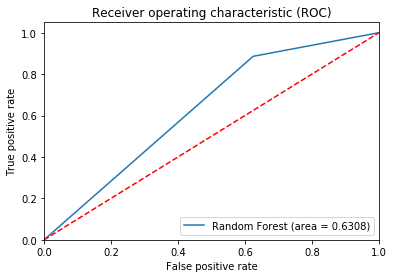

In [43]:
plot_roc_curve(predictions, test_target)

In [44]:
prob_predictions = rf2.predict_proba(test_predictors)[:,1]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished


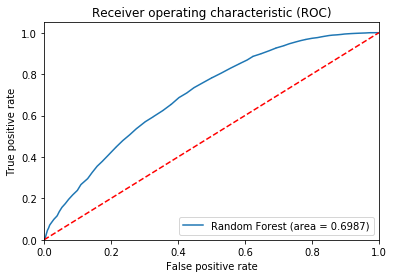

In [45]:
plot_roc_curve(prob_predictions, test_target)

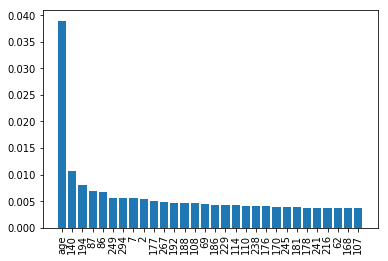

In [46]:
plot_importance_top(rf2, all_features_df)